# Линейная регрессия: практика

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

random_seed = 42
np.random.seed(random_seed)

## Аналитическое решение

Сгенерируем матрицу признаков $X$ и коэффициенты регрессии $\mathbf{w}$. Вектор признаков посчитаем как $Y = X \times \mathbf{w} + \varepsilon$, где $\varepsilon \sim \mathcal{N}(0, 1)$

In [ ]:
num_features = 2
num_objects = 3000

# Генерируем коэффициенты регрессии
w_true = np.random.normal(size=(num_features,))

# Генерируем матрицу признаков
X = np.random.uniform(-5, 5, (num_objects, num_features))

# Генерируем вектор таргетов, добавляя нормальный шум
Y = X @ w_true + np.random.normal(0, 1, num_objects)

Будем решать задачу поиска коэффициентов в случае линейной модели
$$\hat{Y} = X \times \mathbf{w}$$
и квадратичной функции ошибок
$$Q(Y, X, \mathbf{w}) = \sum_i (y_i - \mathbf{x_i}^T\mathbf{w})^2$$

Найдем аналитическое решение по формуле:
$$\mathbf{w}^* = (X^TX)^{-1}X^TY.$$

In [ ]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [ ]:
w_star

In [ ]:
w_true

Можно заметить, что аналитическое решение довольно близко к оригиналу

Теперь сгенерируем датасет с скореллированными признаками

In [ ]:
num_features = 3
num_objects = 3000
batch_size = 10
eps = 1e-3

# Генерируем коэффициенты регрессии
w_true = np.random.normal(size=(num_features,))

# Генерируем матрицу признаков
X = np.random.uniform(-5, 5, (num_objects, num_features))

# Продублируем предпоследний признак с небольшим шумом, сделав признаки 2 и 3 коллинеарными
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, num_objects)

# Генерируем вектор таргетов, добавляя нормальный шум
Y = X @ w_true + np.random.normal(0, 1, num_objects)

In [ ]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [ ]:
w_star

In [ ]:
w_true

Видим что в данном случае коэффициенты у второго и третьего признаков противоположны, это делает нашу модель нестабильной

Исправим это **регуляризацией**

Добавил в функию ошибок слагаемое, отвечающее за $L_2$-норму весов

$$Q_{reg}(Y, X, \mathbf{w}) = \sum_i (y_i - \mathbf{x_i}^T\mathbf{w})^2 + \sum_p w_p^2$$

В таком случае аналитическое решение имеет вид
$$\mathbf{w_{reg}}^* = (X^TX + \lambda I_p)^{-1}X^TY,$$
где $I_p$ это матрица размером $p \times p$ с единицами на диагонали

In [ ]:
w_star_reg = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(num_features)).dot(X.T).dot(Y)
w_star_reg

In [ ]:
w_true

## Градиентный спуск

Суть градиентного спуска состоит в том, что мы итеративно меняем вектор весов, чтобы минимизировать функцию ошибки, двигаясь по антиградиенту
$$\mathbf{w}^{(t + 1)} = \mathbf{w}^{(t)} - \eta_t \nabla Q(\mathbf{w}^{(t)})$$

Для нашей квадратичной функции потерь градиент выглядит так:
$$\nabla Q(\mathbf{w}) = 2X^T(X\mathbf{w} - Y)$$

In [ ]:
num_features = 2
num_objects = 3000
batch_size = 10
num_steps = 20

# Генерируем коэффициенты регрессии
w_true = np.random.normal(size=(num_features,))

# Генерируем матрицу признаков
X = np.random.uniform(-5, 5, (num_objects, num_features))

# Генерируем вектор таргетов, добавляя нормальный шум
Y = X @ w_true + np.random.normal(0, 1, num_objects)

In [ ]:
w = np.random.uniform(-2, 2, num_features)
w_list = [w.copy()]
learning_rate = 1e-2

for i in range(num_steps):
    w -= learning_rate * 2 * X.T @ (X @ w - Y) / num_objects
    w_list.append(w.copy())

w_list = np.array(w_list)

In [ ]:
w

In [ ]:
w_true

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.square(X @ w_list.T - Y[:, None]).mean(axis=0))
plt.ylim(bottom=0)
plt.grid()
plt.show()

## Стохастический градиентный спуск

Отличие стохастического градиентного спуска заключается в том, что градиент считается по батчу. Приведем пример для размера батча 10

In [ ]:
w = np.random.uniform(-2, 2, num_features)
w_list = [w.copy()]
learning_rate = 1e-2

for i in range(2 * batch_size):
    sample_indices = np.random.randint(0, num_objects, batch_size)
    X_batch = X[sample_indices, :]
    Y_batch = Y[sample_indices]
    w -= learning_rate * 2 * X_batch.T @ (X_batch @ w - Y_batch) / batch_size
    w_list.append(w.copy())

w_list = np.array(w_list)

In [ ]:
w

In [ ]:
w_true

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.square(X @ w_list.T - Y[:, None]).mean(axis=0))
plt.ylim(bottom=0)
plt.grid()
plt.show()

## Готовые решения из модуля sklearn

In [ ]:
import seaborn as sns
from sklearn import linear_model, metrics, datasets

Рассмотрим датасет с развитием диабета у людей

In [ ]:
X, Y = datasets.load_diabetes(as_frame=True, return_X_y=True)

In [ ]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [ ]:
Y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

Используем модель из модуля `sklearn` - `LinearRegression`.

Также в этом модуле представлены варианты регрессии с регуляризацией:

1) `Lasso`

2) `Ridge`

3) `ElasticNet`

Эти классы имеют два основных метода:

1) `fit(X, Y)` обучает модель

2) `predict(X)` применяет модель

В качестве метрик будем использовать $MSE$ и $R^2$

Реализуем обучение модели и подсчет метрик без перебора гиперпараметров (`get_result`), а также с перебором гиперпараметра `alpha`, отвечающего за силу влияния регуляризации (`get_result_best_hyperparams`)

In [ ]:
def get_result(model_class, X_train, X_test, Y_train, Y_test):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
    test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
    train_r2 = metrics.r2_score(Y_train, Y_train_pred)
    test_r2 = metrics.r2_score(Y_test, Y_test_pred)
    print(f"Train MSE: {train_mse:.3}")
    print(f"Test MSE: {test_mse:.3}")
    print(f"Train R2: {train_r2:.3}")
    print(f"Test R2: {test_r2:.3}")
    return model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2

In [ ]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

def get_result_best_hyperparams(model_class, X_train, X_test, Y_train, Y_test):
    best_test_mse = np.inf
    best_alpha = None

    for alpha in alphas:
        model = model_class(alpha=alpha)
        model.fit(X_train, Y_train)
        test_mse = metrics.mean_squared_error(Y_test, model.predict(X_test))
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            best_alpha = alpha

    model = model_class(alpha=best_alpha)
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
    test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
    train_r2 = metrics.r2_score(Y_train, Y_train_pred)
    test_r2 = metrics.r2_score(Y_test, Y_test_pred)
    print(f"Train MSE: {train_mse:.3}")
    print(f"Test MSE: {test_mse:.3}")
    print(f"Train R2: {train_r2:.3}")
    print(f"Test R2: {test_r2:.3}")
    return model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2

Разобьем датасет случайным образом на обучающую (_train) и тестовую (_test) части

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9)

Проверим, есть ли коллинеарные признаки. Для этого построим корреляционную матрицу признаков, и проверим есть ли единицы вне главной диагонали

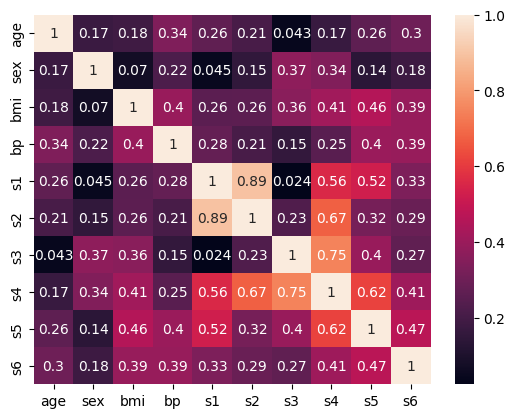

In [ ]:
sns.heatmap(np.abs(X_train.corr()), annot=True)
plt.show()

В данном случае критичных корреляций нет

Лучшей практикой является нормирование признаков, что повышает стабильность и упрощает интерпретируемость

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_scaler.get_feature_names_out())
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_scaler.get_feature_names_out())

Будем сохранять метрики на тестовой выборке по нашим моделям для дальнейшего сравнения

In [ ]:
metrics_values = {
    "test_mse": [],
    "test_r2": []
}
model_name = []

Линейная регрессия

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("LinearRegression")

Train MSE: 2.88e+03
Test MSE: 2.74e+03
Train R2: 0.513
Test R2: 0.551


Для того чтобы понять, какой вклад дают разные переменные, рассмотрим коэффициенты у соответствующих признаков

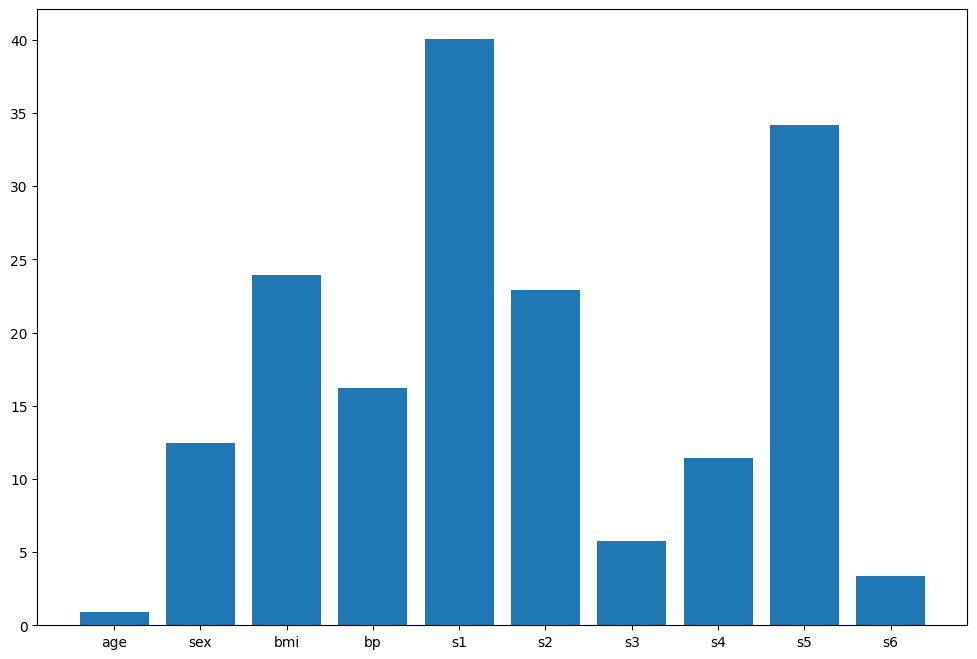

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(X_train.columns, np.abs(model.coef_))
plt.show()

Ridge регрессия с перебором гиперпараметров

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.Ridge, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("Ridge")

Train MSE: 2.89e+03
Test MSE: 2.74e+03
Train R2: 0.511
Test R2: 0.553


Lasso регрессия с перебором гиперпараметров

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.Lasso, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("Lasso")

Train MSE: 2.91e+03
Test MSE: 2.65e+03
Train R2: 0.508
Test R2: 0.566


ElasticNet с перебором гиперпараметров

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.ElasticNet, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("ElasticNet")

Train MSE: 2.9e+03
Test MSE: 2.73e+03
Train R2: 0.51
Test R2: 0.553


Сравним метрики по моделям

In [ ]:
pd.DataFrame(metrics_values, index=model_name)

,test_mse,test_r2
LinearRegression,2743.911238,0.551420
Ridge,2735.262182,0.552834
Lasso,2652.884579,0.566301
ElasticNet,2734.147811,0.553016


Добавим квадраты и попарные произведения исходных признаков, чтобы улучшить качество модели

In [ ]:
num_features = X.shape[1]
for i in range(num_features):
    column = X.columns[i]
    X_train[f"{column}_squared"] = X_train[column] ** 2
    X_test[f"{column}_squared"] = X_test[column] ** 2

    for j in range(i + 1, num_features):
        other_column = X.columns[j]
        X_train[f"{column}_x_{other_column}"] = X_train[column] * X_train[other_column]
        X_test[f"{column}_x_{other_column}"] = X_test[column] * X_test[other_column]

In [ ]:
X_train

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s3_squared,s3_x_s4,s3_x_s5,s3_x_s6,s4_squared,s4_x_s5,s4_x_s6,s5_squared,s5_x_s6,s6_squared
0,-0.329275,-0.910765,-0.750287,-0.542696,0.717209,0.384588,2.091648,-0.812067,-1.467448,-1.636809,...,4.374990,-1.698558,-3.069384,-3.423628,0.659453,1.191666,1.329199,2.153403,2.401932,2.679144
1,-2.041115,-0.910765,-0.773251,-1.543577,-0.798873,-0.554666,0.321516,-0.812067,-1.548855,-0.003897,...,0.103373,-0.261093,-0.497982,-0.001253,0.659453,1.257774,0.003164,2.398950,0.006035,0.000015
2,0.682266,-0.910765,-1.071781,-0.042256,-0.915495,-1.861740,2.476459,-1.575483,-0.375339,0.082046,...,6.132849,-3.901619,-0.929510,0.203184,2.482147,0.591339,-0.129262,0.140879,-0.030795,0.006732
3,-0.407086,-0.910765,-1.806624,-0.542696,-0.740563,-0.692599,0.860252,-1.063994,-1.722560,-0.949267,...,0.740033,-0.915303,-1.481835,-0.816609,1.132084,1.832794,1.010015,2.967213,1.635170,0.901108
4,-1.263006,-0.910765,0.030483,-0.614187,-0.128299,-0.429870,0.244554,-0.048651,0.671290,-1.121153,...,0.059807,-0.011898,0.164167,-0.274182,0.002367,-0.032659,0.054545,0.450631,-0.752619,1.256983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,-2.041115,-0.910765,-1.622914,-0.900153,-0.944651,-0.705735,0.167592,-0.812067,-1.242338,-1.722752,...,0.028087,-0.136096,-0.208205,-0.288719,0.659453,1.008861,1.398990,1.543403,2.140240,2.967874
393,0.137590,1.097978,0.650507,1.745031,-0.769718,-0.968463,0.321516,-0.812067,0.185526,0.339874,...,0.103373,-0.261093,0.059650,0.109275,0.659453,-0.150660,-0.276001,0.034420,0.063056,0.115515
394,0.682266,-0.910765,-0.428793,-0.113747,-0.069988,-0.594075,1.629874,-0.812067,-0.224182,-0.003897,...,2.656490,-1.323567,-0.365389,-0.006351,0.659453,0.182051,0.003164,0.050258,0.000874,0.000015
395,-0.251464,-0.910765,-0.497685,-0.828662,-0.332387,0.121859,-0.371144,-0.048651,-0.801863,-0.777382,...,0.137748,0.018057,0.297607,0.288521,0.002367,0.039011,0.037820,0.642984,0.623354,0.604322


In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_scaler.get_feature_names_out())
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_scaler.get_feature_names_out())

In [ ]:
X_train

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s3_squared,s3_x_s4,s3_x_s5,s3_x_s6,s4_squared,s4_x_s5,s4_x_s6,s5_squared,s5_x_s6,s6_squared
0,-0.329275,-0.910765,-0.750287,-0.542696,0.717209,0.384588,2.091648,-0.812067,-1.467448,-1.636809,...,1.917093,-0.859407,-2.917123,-3.411663,-0.223059,0.541034,0.864063,0.835076,1.820314,1.119828
1,-2.041115,-0.910765,-0.773251,-1.543577,-0.798873,-0.554666,0.321516,-0.812067,-1.548855,-0.003897,...,-0.509311,0.438435,-0.111110,0.287241,-0.223059,0.603164,-0.380449,1.012854,-0.438447,-0.666894
2,0.682266,-0.910765,-1.071781,-0.042256,-0.915495,-1.861740,2.476459,-1.575483,-0.375339,0.082046,...,2.915608,-2.848481,-0.582011,0.508196,0.970810,-0.023165,-0.504734,-0.622012,-0.473169,-0.662415
3,-0.407086,-0.910765,-1.806624,-0.542696,-0.740563,-0.692599,0.860252,-1.063994,-1.722560,-0.949267,...,-0.147669,-0.152231,-1.184729,-0.593996,0.086515,1.143580,0.564502,1.424282,1.097439,-0.065952
4,-1.263006,-0.910765,0.030483,-0.614187,-0.128299,-0.429870,0.244554,-0.048651,0.671290,-1.121153,...,-0.534057,0.663426,0.611452,-0.007741,-0.653452,-0.609611,-0.332227,-0.397749,-1.153678,0.171383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,-2.041115,-0.910765,-1.622914,-0.900153,-0.944651,-0.705735,0.167592,-0.812067,-1.242338,-1.722752,...,-0.552075,0.551291,0.205105,-0.023452,-0.223059,0.369231,0.929563,0.393429,1.573600,1.312383
393,0.137590,1.097978,0.650507,1.745031,-0.769718,-0.968463,0.321516,-0.812067,0.185526,0.339874,...,-0.509311,0.438435,0.497399,0.406700,-0.223059,-0.720511,-0.642451,-0.699090,-0.384691,-0.589867
394,0.682266,-0.910765,-0.428793,-0.113747,-0.069988,-0.594075,1.629874,-0.812067,-0.224182,-0.003897,...,0.940935,-0.520839,0.033581,0.281731,-0.223059,-0.407823,-0.380449,-0.687623,-0.443313,-0.666894
395,-0.251464,-0.910765,-0.497685,-0.828662,-0.332387,0.121859,-0.371144,-0.048651,-0.801863,-0.777382,...,-0.489784,0.690470,0.757067,0.600428,-0.653452,-0.542254,-0.347923,-0.258483,0.143537,-0.263879


In [ ]:
model, Y_train_pred, Y_test_pred, _, _, _, _ = get_result_best_hyperparams(linear_model.Lasso, X_train, X_test, Y_train, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e+05, tolerance: 2.346e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e+05, tolerance: 2.346e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+04, tolerance: 2.346e

Train MSE: 2.61e+03
Test MSE: 2.52e+03
Train R2: 0.558
Test R2: 0.587


Проверим, является ли распределение ошибок нормальным, используя QQplot. Чем ближе точки к диагонали, тем больше распределение похоже на нормальное

In [ ]:
from statsmodels.graphics.gofplots import qqplot

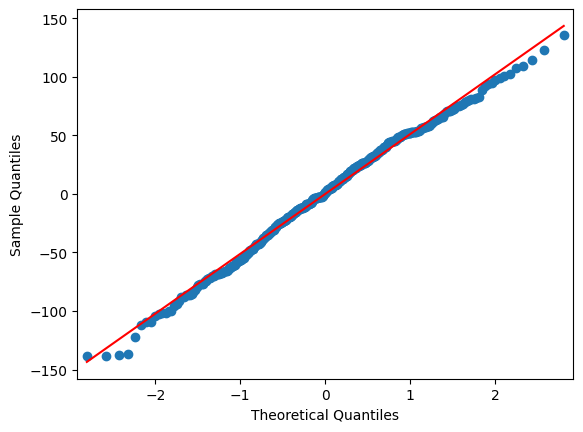

In [ ]:
qqplot(Y_train_pred - Y_train, line='s')
plt.show()

Посмотрим на топ-3 наиболее важных признака

In [ ]:
ind = np.argpartition(np.abs(model.coef_), -3)[-3:]
print(X_train.columns[ind].tolist())

['bp', 's5', 'bmi']
